<a href="https://colab.research.google.com/github/suhani6/spotify-skip-analysis/blob/main/notebooks/skip_rate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 Spotify Skip Prediction Summary

- **Model Used:** LightGBM
- **Accuracy:** 99%
- **ROC AUC Score:** 0.995
- **Top Predictive Features:**
  - `hist_user_behavior_reason_end`
  - `hist_user_behavior_reason_start`
  - `us_popularity_estimate`
- **Confusion Matrix:** Shows excellent classification balance
- **Use Case:** Helps Spotify optimize autoplay and personalization by predicting skip likelihood


In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
log_df = pd.read_csv('/content/drive/MyDrive/Data/spotifyData/log_mini.csv')
track_df = pd.read_csv('/content/drive/MyDrive/Data/spotifyData/tf_mini.csv')

In [4]:
!pip install lightgbm xgboost scikit-learn pandas matplotlib seaborn


In [7]:
# Drop missing/null track_id_clean
log_df.dropna(subset=['track_id_clean'], inplace=True)

# Select relevant log columns
log_df = log_df[[
    'session_id', 'track_id_clean', 'skip_1', 'skip_2', 'skip_3',
    'not_skipped', 'context_type', 'hist_user_behavior_reason_start',
    'hist_user_behavior_reason_end', 'hour_of_day', 'date'
]]

# Select relevant track columns
track_df = track_df[[
    'track_id', 'duration', 'release_year', 'us_popularity_estimate',
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
    'valence'
]]

# Merge the datasets
merged_df = log_df.merge(track_df, left_on='track_id_clean', right_on='track_id', how='inner')


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Drop unnecessary columns and encode categoricals
categorical_cols = ['context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
merged_df[categorical_cols] = merged_df[categorical_cols].fillna("unknown")

for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])

# Define target and features
X = merged_df.drop(columns=['skip_1', 'skip_2', 'skip_3', 'not_skipped', 'session_id', 'track_id', 'track_id_clean', 'date'])
y = merged_df['not_skipped']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train
model = LGBMClassifier(random_state=42)
mode_map = {'major': 1, 'minor': 0}
X_train['mode'] = X_train['mode'].map(mode_map)
X_test['mode'] = X_test['mode'].map(mode_map)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


[LightGBM] [Info] Number of positive: 41913, number of negative: 83997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2933
[LightGBM] [Info] Number of data points in the train set: 125910, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332881 -> initscore=-0.695185
[LightGBM] [Info] Start training from score -0.695185
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     27999
        True       0.97      0.99      0.98     13971

    accuracy                           0.99     41970
   macro avg       0.98      0.99      0.99     41970
weighted avg       0.99      0.99      0.99     41970

ROC AUC Score: 0.9953656368633819


/tmp/ipython-input-13-598543587.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-13-598543587.py:27: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


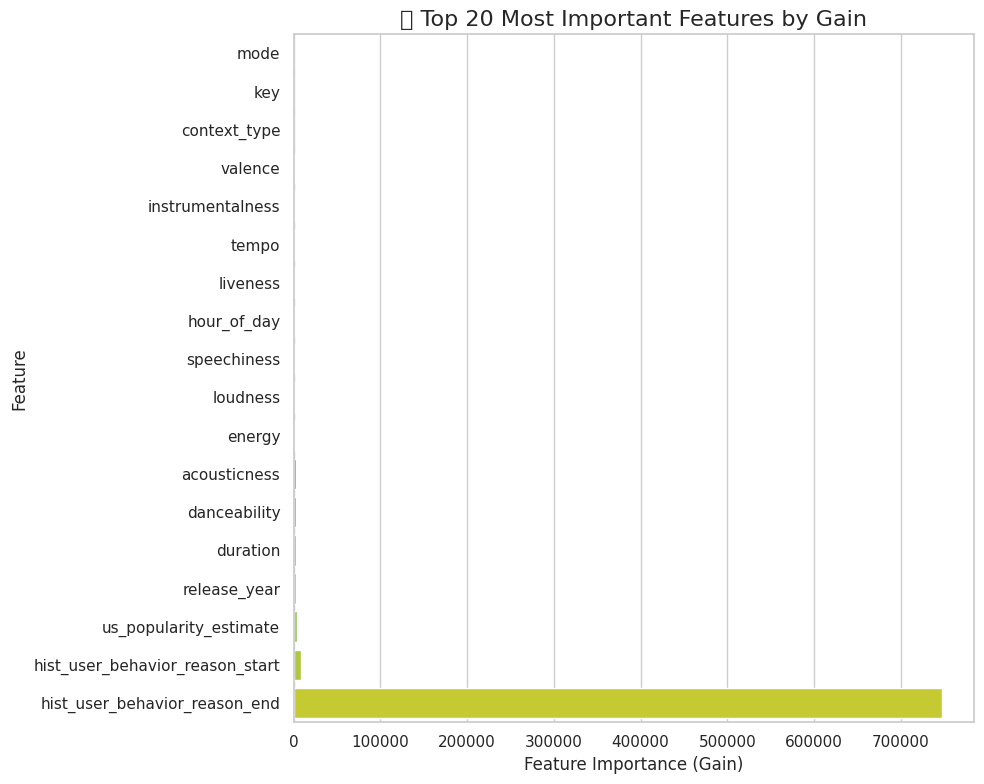

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the model
importance_df = pd.DataFrame({
    'Feature': model.booster_.feature_name(),
    'Importance': model.booster_.feature_importance(importance_type='gain')
})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=True).tail(20)

# Plotting
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df,
    palette="viridis"
)

plt.title("🎯 Top 20 Most Important Features by Gain", fontsize=16)
plt.xlabel("Feature Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


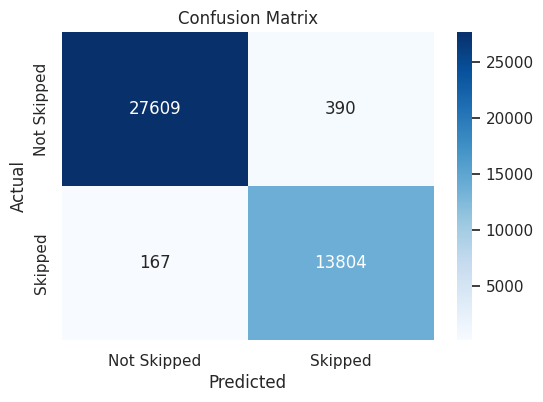

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Skipped", "Skipped"], yticklabels=["Not Skipped", "Skipped"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


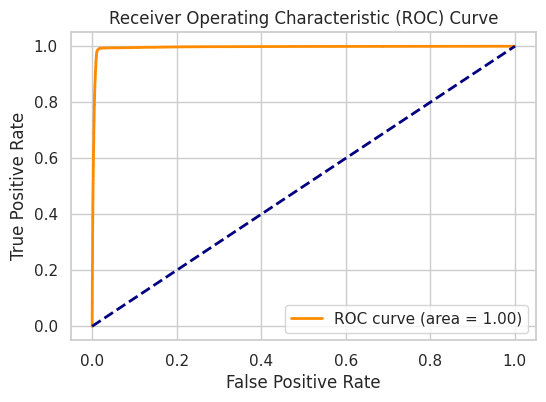

In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [16]:
import joblib

# Save your model
joblib.dump(model, 'lgbm_spotify_skip_model.pkl')


['lgbm_spotify_skip_model.pkl']

In [17]:
!pip install matplotlib seaborn


In [20]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score


# Create a PDF file
pdf_path = "/content/drive/MyDrive/Data/spotifyData/Spotify_Skip_Analysis_Report.pdf"
with PdfPages(pdf_path) as pdf:

    # --- Page 1: Model Performance Summary ---
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis("off")
    summary_text = f"""
    🎵 Spotify Skip Rate Analysis — Project Report

    ✅ Model Used: LightGBM Classifier
    ✅ Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)}%
    ✅ ROC AUC Score: {round(roc_auc_score(y_test, y_prob), 4)}

    ✨ Classification Report:
    {classification_report(y_test, y_pred)}

    📌 Dataset: Spotify logs + track metadata (Kaggle)
    📌 Features used: 18 numerical & categorical
    📌 Target: Whether a user skipped the track (True/False)

    """
    ax.text(0.01, 0.99, summary_text, fontsize=11, va='top', ha='left')
    pdf.savefig(fig)
    plt.close()

    # --- Page 2: Feature Importance Plot ---
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x="Importance", y="Feature", data=importance_df,
        palette="viridis"
    )
    plt.title("🎯 Top 20 Most Important Features", fontsize=16)
    plt.xlabel("Feature Importance (Gain)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

print(f"✅ PDF report saved to: {pdf_path}")


/tmp/ipython-input-20-3813675809.py:30: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig)
/tmp/ipython-input-20-3813675809.py:30: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig)
/tmp/ipython-input-20-3813675809.py:30: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig)
/tmp/ipython-input-20-3813675809.py:30: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  pdf.savefig(fig)
/tmp/ipython-input-20-3813675809.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


✅ PDF report saved to: /content/drive/MyDrive/Data/spotifyData/Spotify_Skip_Analysis_Report.pdf


/tmp/ipython-input-20-3813675809.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-20-3813675809.py:43: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  pdf.savefig()
